In [1]:
import numpy as np # linear algebra
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid")
import warnings
warnings.filterwarnings('ignore')
import util

<h2 style="color: #dddda1">Data Initialization</h2>

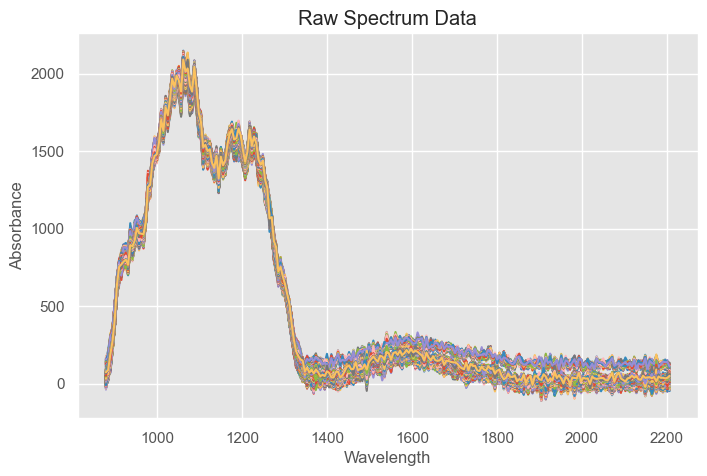

In [2]:
file_name = ['2022_07_13.csv', '2022_06_22.csv', '2022_06_24.csv', '2022_06_29.csv']
X, y, wl = util.data_initialization(filename=file_name[1], sep=";", drop_columns=['Timestamp', 'TS_sim'], index_column='Timestamp', y_data_column='TS_sim')
util.plot(wl, X, title='Raw Spectrum Data', xlabel='Wavelength', ylabel='Absorbance')

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

scaler = StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
X_train = pd.DataFrame(X_train_scaled)
X_train.columns = X.columns
X_test = pd.DataFrame(X_test_scaled)
X_test.columns = X.columns
X_train

,883.108,889.669,896.213,902.739,909.247,915.738,922.211,928.667,935.106,941.528,...,2165.951,2170.517,2175.081,2179.645,2184.209,2188.772,2193.334,2197.896,2202.458,2207.019
0,1.207801,0.170217,0.716235,-0.171138,0.511586,0.490362,2.059323,-0.977535,0.947373,-0.919276,...,0.793577,0.120635,0.361097,0.183856,0.719955,0.176483,1.053928,0.737374,0.697446,0.361805
1,-0.563959,-0.228532,-0.859501,-0.071264,-0.201433,-0.181227,-1.135447,0.026956,-0.422928,-0.177306,...,-0.821766,0.250890,-0.600111,0.125650,-1.176758,-0.570680,-0.571342,-0.429534,-0.680607,-0.182136
2,-1.697886,-1.011530,-1.413396,-0.437468,-1.161826,-0.544248,-1.333792,-1.209341,-0.863944,-1.270735,...,-0.558525,-0.881766,-0.909761,-1.135480,-0.569810,-1.584686,-0.909688,-1.009965,-0.733355,-1.364032
3,0.262862,-0.641781,0.429738,0.594561,0.715305,-0.090472,0.982593,0.155737,0.600860,-0.450663,...,0.362819,0.233900,0.025642,-0.223586,-0.300822,0.416642,-0.057781,0.495528,-0.014658,-0.067975
4,-0.445842,-0.953530,-0.668502,0.228357,-0.434256,-1.851124,-1.163782,-0.625534,-0.863944,-0.919276,...,-0.534594,-0.383397,-0.625915,-0.301194,-0.487045,-0.170414,-0.450504,-0.671380,0.057871,-0.665639
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1147,0.735332,0.634216,0.410638,0.394813,0.307866,0.780779,0.755913,-0.531095,0.222846,0.174153,...,-0.139733,0.097982,0.541726,-0.048968,0.333715,-0.010308,-0.081948,0.616451,0.460078,0.845308
1148,0.168369,0.170217,0.009542,-0.470759,-0.303293,0.272549,0.359223,-0.874511,-0.186669,0.408460,...,0.003853,-0.626918,-0.077575,0.436082,0.140595,-0.036992,0.111392,0.495528,-0.278400,0.737863
1149,-1.438028,-0.924530,-0.553903,-1.802409,-1.307341,-0.870967,-1.135447,-1.415391,-1.115954,-0.489714,...,-0.965352,-0.995031,-1.012978,-0.766842,-1.452644,-1.397895,-1.344705,-1.130888,-0.944349,-0.961113
1150,0.640838,0.460216,0.372438,-0.803671,0.336969,0.853383,1.747638,-0.325045,0.285849,0.017949,...,0.314957,0.800228,0.257880,-0.475812,0.747543,0.069745,0.449738,0.640635,0.011716,0.549834


In [5]:
from sklearn.linear_model import Lasso

reg = Lasso(alpha=1)
reg.fit(X_train, y_train)

Lasso(alpha=1)

<h4 style="color: teal">Model Evaluation</h4>

In [6]:
print('R squared training set', round(reg.score(X_train, y_train)*100, 2))
print('R squared test set', round(reg.score(X_test, y_test)*100, 2))

R squared training set 74.53
R squared test set 73.89


In [7]:
from sklearn.metrics import mean_squared_error

# Training data
pred_train = reg.predict(X_train)
mse_train = mean_squared_error(y_train, pred_train)
print('MSE training set', round(mse_train, 2))

# Test data
pred = reg.predict(X_test)
mse_test =mean_squared_error(y_test, pred)
print('MSE test set', round(mse_test, 2))

MSE training set 3.35
MSE test set 3.74


<h4 style="color: #cc4455">Adjusting Alpha</h4>

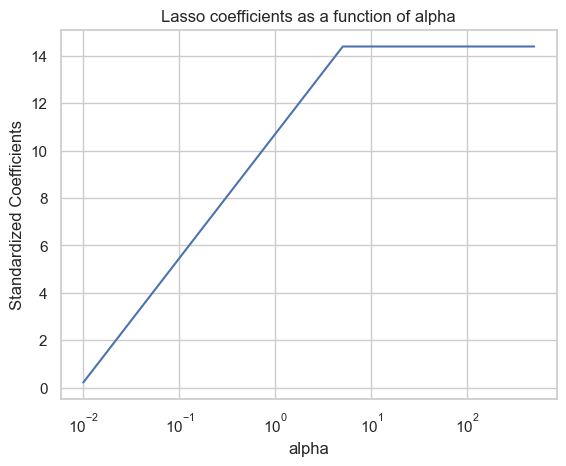

In [8]:
import numpy as np
import matplotlib.pyplot as plt

alphas = np.linspace(0.01,500,100)
lasso = Lasso(max_iter=10000)
coefs = []
test_mse = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(X_train, y_train)
    coefs.append(lasso.coef_)
    test_mse.append(mean_squared_error(lasso.predict(X_test), y_test))

ax = plt.gca()

ax.plot(alphas, test_mse)
ax.set_xscale('log')
plt.axis('tight')
plt.xlabel('alpha')
plt.ylabel('Standardized Coefficients')
plt.title('Lasso coefficients as a function of alpha');

<p>Next, we use cross-validation to find the best value for alpha.</p>

<h5 style="color: teal">Optimal Alpha using K-Folds cross validation</h5>

In [16]:
from sklearn.linear_model import LassoCV

# Lasso with 5 fold cross-validation
model = LassoCV(cv=5, random_state=0, max_iter=10000)

# Fit model
model.fit(X_train, y_train)

LassoCV(cv=5, max_iter=10000, random_state=0)

In [17]:
model.alpha_

0.0030874837788565004

<h4 style="color: #ccdd55">Running with best Alpha value</h4>

In [18]:
# Set best alpha
lasso_best = Lasso(alpha=model.alpha_)
lasso_best.fit(X_train, y_train)

Lasso(alpha=0.0030874837788565004)

In [19]:
print(list(zip(lasso_best.coef_, X)))

[(-0.04373767670936338, '883.108'), (-0.01706755489249504, '889.669'), (0.0, '896.213'), (-0.014303718756130145, '902.739'), (-0.290823853246297, '909.247'), (0.02553801230561071, '915.738'), (-0.09372853134306589, '922.211'), (-0.06010560804922833, '928.667'), (-0.052890061581905304, '935.106'), (-0.004115105634558271, '941.528'), (-0.08171080000042732, '947.932'), (-0.0901520138214878, '954.32'), (-0.048398739242934655, '960.69'), (-0.15620817746128354, '967.044'), (-0.0, '973.382'), (-0.02648439252057812, '979.702'), (-0.017702593932568504, '986.007'), (-0.0, '992.294'), (-0.04730298571616819, '998.566'), (-0.10858393453488485, '1004.821'), (-0.08499574643122983, '1011.061'), (-0.08366437071525026, '1017.284'), (-0.23853200900455482, '1023.491'), (-0.08548794993824191, '1029.683'), (-0.08370579483856297, '1035.859'), (-0.0, '1042.019'), (-0.05668606215004773, '1048.163'), (-0.03452705865334785, '1054.293'), (-0.045757865499419494, '1060.406'), (-0.07504545955550718, '1066.505'), (-0

<h4 style="color: #11cc44">Model Evaluation</h4>

In [20]:
print('R squared training set', round(lasso_best.score(X_train, y_train)*100, 2))
print('R squared test set', round(lasso_best.score(X_test, y_test)*100, 2))

R squared training set 99.1
R squared test set 98.6


In [21]:
mean_squared_error(y_test, lasso_best.predict(X_test))

0.2002010138107063

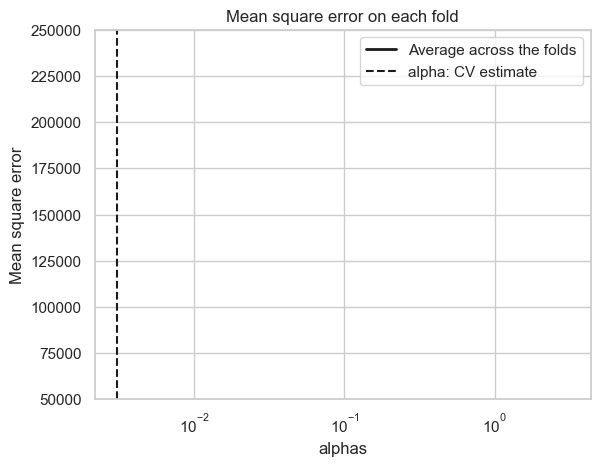

In [22]:
plt.semilogx(model.alphas_, model.mse_path_, ":")
plt.plot(
    model.alphas_ ,
    model.mse_path_.mean(axis=-1),
    "k",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(
    model.alpha_, linestyle="--", color="k", label="alpha: CV estimate"
)

plt.legend()
plt.xlabel("alphas")
plt.ylabel("Mean square error")
plt.title("Mean square error on each fold")
plt.axis("tight")

ymin, ymax = 50000, 250000
plt.ylim(ymin, ymax);